In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

In [21]:
df = pd.read_csv('ObesityDataSet.csv')

In [22]:
print(df.head())
print(df.info())
print(df.describe())

print("Missing Values:\n", df.isnull().sum())
print("Duplicate Rows: ", df.duplicated().sum())
print("Unique Values per Column:\n", df.nunique())
print("Class Balance:\n", df['NObeyesdad'].value_counts())

  Age  Gender Height Weight        CALC FAVC FCVC NCP  SCC SMOKE CH2O  \
0  21  Female   1.62     64          no   no    2   3   no    no    2   
1  21  Female   1.52     56   Sometimes   no    3   3  yes   yes    3   
2  23    Male    1.8     77  Frequently   no    2   3   no    no    2   
3  27    Male    1.8     87  Frequently   no    3   3   no    no    2   
4  22    Male   1.78   89.8   Sometimes   no    2   1   no    no    2   

  family_history_with_overweight FAF TUE       CAEC                 MTRANS  \
0                            yes   0   1  Sometimes  Public_Transportation   
1                            yes   3   0  Sometimes  Public_Transportation   
2                            yes   2   1  Sometimes  Public_Transportation   
3                             no   2   0  Sometimes                Walking   
4                             no   0   0  Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1        Normal_Weight  
2        Normal_W

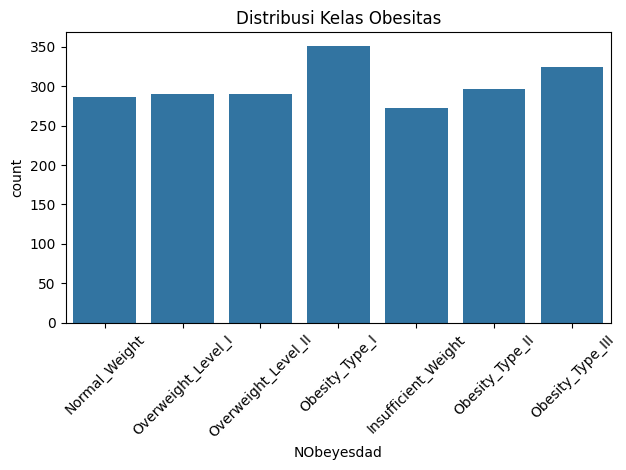

In [23]:
sns.countplot(x='NObeyesdad', data=df)
plt.xticks(rotation=45)
plt.title("Distribusi Kelas Obesitas")
plt.tight_layout()
plt.show()

In [25]:
# Cek ulang apakah kolom numerik sudah benar-benar bertipe float atau int
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Tampilkan boxplot satu per satu agar lebih jelas
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot((len(numeric_cols)+2)//3, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


<Figure size 1500x800 with 0 Axes>

In [26]:
# Drop duplikat jika ada
df.drop_duplicates(inplace=True)

# Encoding variabel kategorikal
label_cols = df.select_dtypes(include='object').columns.tolist()
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Cek lagi hasil encode
print(df.head())

    Age  Gender  Height  Weight  CALC  FAVC  FCVC  NCP  SCC  SMOKE  CH2O  \
0   404       1     291     947     4     1   167  479    1      1   545   
1   404       1      27     875     3     1   798  479    2      2  1253   
2   697       2    1285    1082     2     1   167  479    1      1   545   
3  1012       2    1285    1340     2     1   798  479    1      1   545   
4   578       2    1182    1388     3     1   167    0    1      1   545   

   family_history_with_overweight   FAF  TUE  CAEC  MTRANS  NObeyesdad  
0                               2     0  832     3       4           1  
1                               2  1180    0     3       4           1  
2                               2  1063  832     3       4           1  
3                               1  1063    0     3       5           5  
4                               1     0    0     3       4           6  


In [27]:
# Pisahkan fitur dan target
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tangani imbalance dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [28]:
models = {
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    print(f"\nModel: {name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Model: RandomForest
[[68  3  0  0  0  0  0]
 [ 0 65  0  0  0  4  2]
 [ 0  1 62  1  0  0  1]
 [ 0  1  0 67  1  0  0]
 [ 0  0  1  0 72  0  0]
 [ 0  6  0  0  0 57  1]
 [ 0  3  3  0  0  1 72]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        71
           1       0.82      0.92      0.87        71
           2       0.94      0.95      0.95        65
           3       0.99      0.97      0.98        69
           4       0.99      0.99      0.99        73
           5       0.92      0.89      0.90        64
           6       0.95      0.91      0.93        79

    accuracy                           0.94       492
   macro avg       0.94      0.94      0.94       492
weighted avg       0.94      0.94      0.94       492


Model: KNN
[[64  5  0  0  0  0  2]
 [11 33  3  5  0  7 12]
 [ 0  2 52  5  0  1  5]
 [ 1  0  2 65  1  0  0]
 [ 0  0  1  0 72  0  0]
 [ 3  4  8  0  0 46  3]
 [ 2  7  3  1  0  7 59]]
              precision    recal

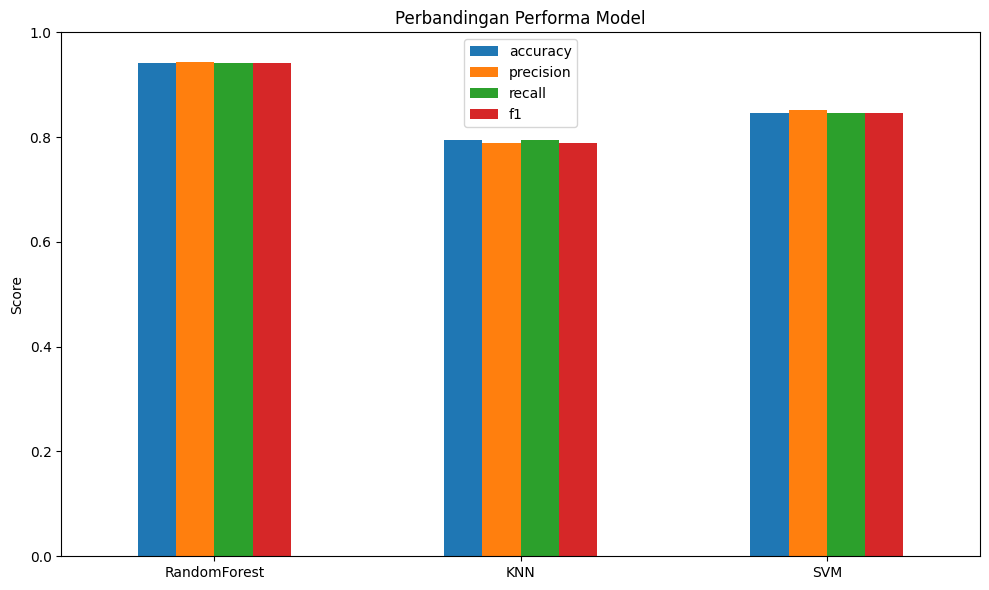

In [29]:
df_result = pd.DataFrame(results).T
df_result.plot(kind='bar', figsize=(10, 6), title="Perbandingan Performa Model")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\nBest Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred_best))


Best Parameters: {'max_depth': 20, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        71
           1       0.80      0.96      0.87        71
           2       0.91      0.95      0.93        65
           3       0.99      0.97      0.98        69
           4       0.99      0.99      0.99        73
           5       0.93      0.86      0.89        64
           6       0.97      0.89      0.93        79

    accuracy                           0.94       492
   macro avg       0.94      0.94      0.94       492
weighted avg       0.94      0.94      0.94       492



In [31]:
import joblib
joblib.dump(best_model, "obesity_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']